In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import os
import shutil
import numpy as np
from sklearn.utils.class_weight import compute_class_weight


Menyiapkan Dataset


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Ganti path ke lokasi file 'kaggle.json' Anda di Google Drive
kaggle_json_path = '/content/drive/MyDrive/kaggle_api/kaggle.json'

# Membuat direktori .kaggle jika belum ada
!mkdir -p ~/.kaggle

# Menyalin file kaggle.json ke folder .kaggle
shutil.copy(kaggle_json_path, '/root/.kaggle/kaggle.json')


'/root/.kaggle/kaggle.json'

In [4]:
!kaggle datasets download -d jedalosa/waste-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/jedalosa/waste-classification-dataset
License(s): CC-BY-SA-4.0
100% 214M/215M [00:10<00:00, 22.7MB/s]
100% 215M/215M [00:10<00:00, 20.9MB/s]


In [5]:
import zipfile

# Ekstrak dataset ZIP ke folder yang diinginkan
with zipfile.ZipFile('/content/waste-classification-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/waste-classification-dataset-folder')

Pre-Processing Dataset


Split Dataset Menjadi Train Set dan Validation Set

In [9]:
# Path dataset
dataset_path = "waste-classification-dataset-folder/waste_clasification_image_sets/"  # Folder utama dengan sub-folder kelas

# Membuat dataset untuk train dan validation
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,      # Proporsi untuk validation (20%)
    subset="training",         # Subset untuk data train
    seed=42,                   # Seed untuk reproducibility
    image_size=(128, 128),     # Ukuran gambar
    batch_size=32              # Ukuran batch
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,      # Proporsi untuk validation harus sama
    subset="validation",       # Subset untuk data validation
    seed=42,
    image_size=(128, 128),
    batch_size=32
)


Found 25077 files belonging to 2 classes.
Using 20062 files for training.
Found 25077 files belonging to 2 classes.
Using 5015 files for validation.


In [10]:
from collections import Counter

# Cek distribusi kelas dalam train_dataset
class_counts = Counter()
for _, labels in train_dataset.unbatch():  # `unbatch` untuk mendapatkan semua data
    class_counts.update([labels.numpy()])

print("Distribusi kelas di training set:")
for class_index, count in class_counts.items():
    print(f"Kelas {class_index}: {count} sampel")


Distribusi kelas di training set:
Kelas 0: 11220 sampel
Kelas 1: 8842 sampel


Menggunakan Class Weight untuk menyeimbangkan data

In [8]:
for _, y in train_dataset.take(5):
    print("Label shape:", y.shape)
    print("Label value:", y.numpy())


Label shape: (64,)
Label value: [1 1 1 1 1 1 0 1 0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 1 0 0 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 1]
Label shape: (64,)
Label value: [1 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1
 1 1 0 0 0 1 0 0 1 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 1 0]
Label shape: (64,)
Label value: [1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 0 0 1 0 0
 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 1 0 1]
Label shape: (64,)
Label value: [0 1 1 0 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1
 0 1 0 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 1 1 0 1]
Label shape: (64,)
Label value: [1 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 1
 0 0 0 1 1 0 0 1 1 1 1 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 1]


In [11]:
y_train = np.concatenate([np.reshape(y.numpy(), (-1,)) for _, y in train_dataset.unbatch()])


In [12]:
# Pastikan label dalam bentuk yang benar
print("y_train shape:", y_train.shape)
print("Unique classes in y_train:", np.unique(y_train))


y_train shape: (20062,)
Unique classes in y_train: [0 1]


In [13]:
# Hitung class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
# Konversi ke dictionary
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.8940285204991087, 1: 1.1344718389504638}


In [14]:
class_weights_dict = {0: 1.0, 1: 5.0}  # Coba tingkatkan bobot kelas minoritas


In [15]:
# Normalisasi dataset
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset = train_dataset.map(normalize)
validation_dataset = validation_dataset.map(normalize)

In [16]:
# Optimize the datasets for training
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (train_dataset
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       )

validation_dataset_final = (validation_dataset
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                            )

Membuat Model

In [18]:
model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(128, 128, 3)),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

# Print the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,516,546 (24.86 MB)

 Trainable params: 6,516,546 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Augmentasi pada train set
data_augmentation = tf.keras.Sequential([
    tf.keras.Input(shape=(128, 128, 3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.4),
    tf.keras.layers.RandomTranslation(0.2,0.2),
    tf.keras.layers.RandomContrast(0.4),
    tf.keras.layers.RandomZoom(0.2)
])

# Attach the data augmentation model to the base model
model_with_aug = tf.keras.models.Sequential([
    data_augmentation,
    model
])

In [20]:
# Set the training parameters
model_with_aug.compile(loss = 'sparse_categorical_crossentropy',  optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [21]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy'] >= 0.85:
            self.model.stop_training = True
            print("\nReached 85% accuracy so cancelling training!")

In [39]:
# Train the model
history = model_with_aug.fit(
    train_dataset_final,
    epochs=10,
    validation_data = validation_dataset_final,
    verbose=1,
    callbacks=[EarlyStoppingCallback()]
)

Epoch 1/10
626/627 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8534 - loss: 0.3430
Reached 85% accuracy so cancelling training!
627/627 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.8534 - loss: 0.3430 - val_accuracy: 0.8704 - val_loss: 0.3215


In [40]:
loss, accuracy = model_with_aug.evaluate(validation_dataset)
print(f"Validation Accuracy: {accuracy:.2f}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8651 - loss: 0.3240
Validation Accuracy: 0.87


In [64]:
y_pred = []
y_true = []

for images, labels in validation_dataset:
    predictions = model.predict(images)
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())  # Prediksi kelas
    y_true.extend(labels.numpy())  # Label sebenarnya


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

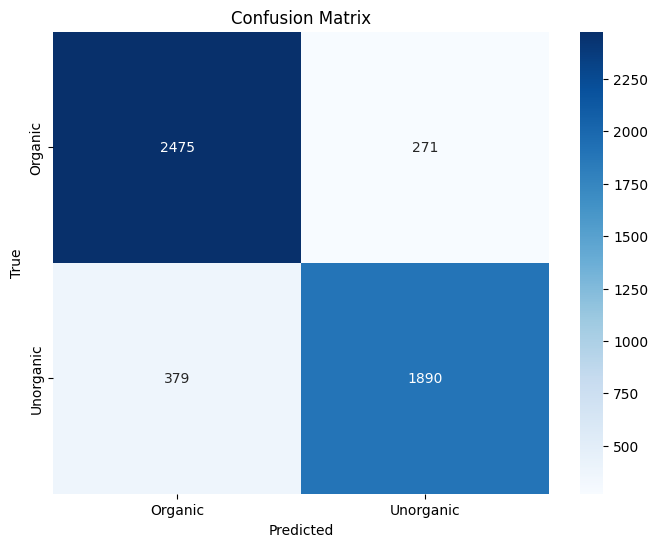

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung matriks kebingungan
cm = confusion_matrix(y_true, y_pred)

# Visualisasi matriks kebingungan
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Organic', 'Unorganic'],
            yticklabels=['Organic', 'Unorganic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [43]:
model.save('image_classifier_model.h5')

# Untuk memuat model
# from tensorflow.keras.models import load_model
# loaded_model = load_model('waste_classifier_model.h5')


In [50]:
from PIL import Image
import numpy as np

# Dictionary untuk klasifikasi sampah
waste_classification_dict = {
    0: 'organic',
    1: 'unorganic',
}

# Fungsi untuk memuat gambar dan mengubahnya menjadi format yang sesuai untuk model
def preprocess_image(image_path, target_size=(128, 128)):
    image = Image.open(image_path).convert("RGB")  # Memastikan gambar dalam format RGB
    image = image.resize(target_size)  # Mengubah ukuran gambar
    image_array = np.array(image) / 255.0  # Normalisasi nilai pixel ke 0-1
    image_array = np.expand_dims(image_array, axis=0)  # Menambahkan dimensi batch
    return image_array

# Fungsi prediksi jenis sampah
def predict_waste_type_image(image_path, model):
    # Preprocess gambar
    input_image = preprocess_image(image_path)
    # Mendapatkan probabilitas prediksi dari model
    predicted_probabilities = model.predict(input_image)[0]
    # Menentukan label dengan probabilitas tertinggi
    predicted_label = np.argmax(predicted_probabilities)
    # Mendapatkan jenis sampah berdasarkan label
    predicted_waste = waste_classification_dict[predicted_label]
    return f"Masukan gambar tergolong sebagai sampah {predicted_waste}"

# Memuat model (ganti path dengan lokasi model yang sudah dilatih)
model = tf.keras.models.load_model('image_classifier_model.h5')

# Contoh penggunaan
image_path = "kardus.jfif"  # Ganti dengan path ke gambar Anda
print(predict_waste_type_image(image_path, model))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Masukan gambar tergolong sebagai sampah unorganic


In [51]:
from google.colab import files

# Unduh model
files.download('image_classifier_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
import tensorflow as tf

# Muat model Keras
model = tf.keras.models.load_model('image_classifier_model.h5')

# Konversi model ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open('model_waste_classification.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model berhasil dikonversi ke TFLite.")


Saved artifact at '/tmp/tmpmlle9gs1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  138923891998416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138923274075152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138923274070224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138923256046944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138923274066000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138923256051872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138923274201648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138923274202528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138923274204464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138923287432704: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model berhasil 

In [53]:
from google.colab import files

# Unduh model TFLite
files.download('model_waste_classification.tflite')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
!pip freeze > requirements.txt
